# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 使用葉編碼並觀察預測效果

# [作業重點]
- 仿造範例, 完成葉編碼的寫作 : 使用隨機森林 (In[3], Out[3], In[4], Out[4])
- 仿造範例, 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[5], Out[5], In[6], Out[6]) 

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
train_X = df.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

In [4]:
# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
rf = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                            max_features=4, max_depth=3, bootstrap=True)
onehot = OneHotEncoder(categories='auto')
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

"""
Your Code Here (Hint : 隨機森林的葉編碼(.apply)不需要加上[:, :, 0], 直接用rf.apply()調用即可, 本作業其餘寫法相同)
"""

rf.fit(train_X, train_Y)
onehot.fit(rf.apply(train_X))
lr.fit(onehot.transform(rf.apply(val_X)), val_Y)

print(f"rf.apply(train_X).shape: {rf.apply(val_X).shape}")

rf.apply(train_X).shape: (223, 20)


In [5]:
help(rf.apply)

Help on method apply in module sklearn.ensemble.forest:

apply(X) method of sklearn.ensemble.forest.RandomForestClassifier instance
    Apply trees in the forest to X, return leaf indices.
    
    Parameters
    ----------
    X : array-like or sparse matrix, shape = [n_samples, n_features]
        The input samples. Internally, its dtype will be converted to
        ``dtype=np.float32``. If a sparse matrix is provided, it will be
        converted into a sparse ``csr_matrix``.
    
    Returns
    -------
    X_leaves : array_like, shape = [n_samples, n_estimators]
        For each datapoint x in X and for each tree in the forest,
        return the index of the leaf x ends up in.



In [6]:
# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
pred_rf_lr = lr.predict_proba(onehot.transform(rf.apply(test_X)))[:, 1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(test_Y, pred_rf_lr)

# 將隨機森林結果輸出
pred_rf = rf.predict_proba(test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_Y, pred_rf)

In [7]:
from sklearn.metrics import accuracy_score

thres = 0.5
print(f"Score: rf={accuracy_score(test_Y, pred_rf > thres):.5f}, rf_lr={accuracy_score(test_Y, pred_rf_lr > thres):.5f}")

Score: rf=0.76233, rf_lr=0.77803


# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?

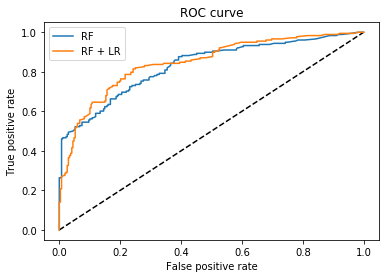

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
# 將結果繪圖
"""
Your Code Here 
"""
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## PlayGround

multi-class

In [9]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

gdbt = GradientBoostingClassifier()
lr = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='ovr')
x, y = make_classification(n_samples=1000, n_classes=3, n_informative=3)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=9453)
gdbt.fit(train_x, train_y)
onehot = OneHotEncoder(categories='auto')

print(f"gdbt.apply(train_x).shape: {gdbt.apply(train_x).shape}\n-")
enc_train_x = onehot.fit_transform(gdbt.apply(train_x).reshape(train_x.shape[0], -1))
enc_test_x = onehot.transform(gdbt.apply(test_x).reshape(test_x.shape[0], -1))

print(f"train_x: {train_x.shape}, enc_train_x: {enc_train_x.shape},\n"
      f"test_x: {test_x.shape}, enc_test_x: {enc_test_x.shape}\n-")

lr.fit(enc_train_x, train_y)
lr_score = lr.score(
    enc_test_x,
    test_y
)
gdbt_score = gdbt.score(test_x, test_y)

print(f"Score: gdbt={gdbt_score}, gdbt_lr={lr_score}")

gdbt.apply(train_x).shape: (800, 100, 3)
-
train_x: (800, 20), enc_train_x: (800, 2260),
test_x: (200, 20), enc_test_x: (200, 2260)
-
Score: gdbt=0.83, gdbt_lr=0.86


In [10]:
help(gdbt.apply)

Help on method apply in module sklearn.ensemble.gradient_boosting:

apply(X) method of sklearn.ensemble.gradient_boosting.GradientBoostingClassifier instance
    Apply trees in the ensemble to X, return leaf indices.
    
    .. versionadded:: 0.17
    
    Parameters
    ----------
    X : {array-like, sparse matrix}, shape (n_samples, n_features)
        The input samples. Internally, its dtype will be converted to
        ``dtype=np.float32``. If a sparse matrix is provided, it will
        be converted to a sparse ``csr_matrix``.
    
    Returns
    -------
    X_leaves : array-like, shape (n_samples, n_estimators, n_classes)
        For each datapoint x in X and for each tree in the ensemble,
        return the index of the leaf x ends up in each estimator.
        In the case of binary classification n_classes is 1.

